### Statistical description of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from brainconn.centrality import participation_coef
from brainconn.modularity import modularity_louvain_dir, modularity_louvain_und
from frites.conn.conn_tf import _create_kernel, _smooth_spectra
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.stats import ks_2samp, mannwhitneyu, ttest_1samp
from statannot import add_stat_annotation
from tqdm import tqdm
from utils import *

from config import get_dates, return_evt_dt
from GDa.graphics import plot
from GDa.loader import loader
from GDa.stats.bursting import find_activation_sequences, find_start_end
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi

#### Auxiliar functions

In [3]:
import numba as nb


@nb.jit(nopython=True)
def _hamming(x, y):
    """
    Calculate the Hamming distance between two arrays.

    The Hamming distance is the number of positions at which the corresponding elements are different.

    Parameters:
    x (ndarray): first array
    y (ndarray): second array
    Returns:
    float: The Hamming distance as a proportion of the maximum possible Hamming distance.
    """
    # sum_and = np.logical_and(x, y).sum()
    max_sum = np.min([x.sum(), y.sum()])
    return sum_and / max_sum


@nb.jit(nopython=True)
def hamming(x, y):

    nroi, ntrials, ntimes = x.shape

    dists = np.zeros((nroi, ntrials))

    for i in range(ncols):
        dists[:, i] = _hamming(x[:, i, :], y[:, i, :])

    return dists


def return_consensus_vector(A, fmod=modularity_louvain_und, nruns=None, verbose=False):
    """
    Return the consensus vector for a given set of community assignments.

    This function takes a matrix of community assignments (A), a modularity function (fmod), and the number of runs (nruns)
    to return the consensus vector of the assignments. The consensus vector is calculated by averaging the affiliation vectors of each run.

    Parameters:
    A (ndarray or xr.DataArray): matrix of community assignments.
    fmod (callable): modularity function used to calculate community assignments. Default is louvain method.
    nruns (int): number of runs to calculate consensus vector over. Default is None.
    Returns:
    Tuple: (idx, q) where idx is the community assignments and q is the modularity score
    """
    nC = len(A)

    if isinstance(A, xr.DataArray):
        A = A.data

    # Creates consensus vector for different runs
    av = []
    for i in tqdm(range(nruns)) if verbose else range(nruns):
        idx, _ = fmod(A, seed=i * 1000)
        av += [idx]
    av = np.stack(av)

    def _for_frame(av):
        # Allegiance for a frame
        T = np.zeros((nC, nC))
        # Affiliation vector
        # For now convert affiliation vector to igraph format
        n_comm = int(av.max() + 1)
        for j in range(n_comm):
            p_lst = np.arange(nC, dtype=int)[av == j]
            grid = np.meshgrid(p_lst, p_lst)
            grid = np.reshape(grid, (2, len(p_lst) ** 2)).T
            T[grid[:, 0], grid[:, 1]] = 1
        np.fill_diagonal(T, 0)
        return T

    T = []
    for i in range(nruns):
        T += [_for_frame(av[i])]

    T = np.stack(T).mean(0)

    return modularity_louvain_und(T)


@nb.jit(nopython=True)
def co_crackling_adj(A):
    """
    Calculate the co-crackling matrix for a given matrix adjacency.

    Parameters:
    A (ndarray): matrix of community assignments where rows are rois and columns are time points
    Returns:
    ndarray: 3-D co-crackling matrix, where the last dimension corresponds to time point.
    """
    nroi, nobs = A.shape

    out = np.zeros((nroi, nroi, nobs))

    for T in range(nobs):
        idx = A[:, T]
        out[..., T] = np.outer(idx, idx)
        np.fill_diagonal(out[..., T], 0)

    return out


def plot_adj_modular(
    A, ci, offset=0.5, vmin=0, vmax=0.05, cmap="turbo", lw=5, color="k"
):
    """
    Plot a modular adjacency matrix with community boundaries.

    This function takes a adjacency matrix (A), a vector of community indices (ci), and optional arguments for
    plotting the matrix (offset, vmin, vmax, cmap, lw, color) and plots the adjacency matrix with lines denoting
    the boundaries between communities.

    Parameters:
    A (ndarray or xr.DataArray): adjacency matrix
    ci (ndarray): vector of community indices for each node in the adjacency matrix
    offset (float): offset for the community boundaries. Default is 0.5
    vmin (float): minimum value for color map. Default is 0
    vmax (float): maximum value for color map. Default is 0.05
    cmap (str): name of colormap to use. Default is 'turbo'
    lw (float): width of the lines used to draw the community boundaries. Default is 5
    color (str): color of the lines used to draw the community boundaries. Default is 'k'
    """
    _, c = np.unique(ci, return_counts=True)

    N = len(A)

    c = np.cumsum(c)
    c = np.hstack(([0], c))

    idx = np.argsort(ci)
    rois = A.sources.data[idx]

    if isinstance(A, xr.DataArray):
        plot_data = A.data[np.ix_(idx, idx)]
    else:
        plot_data = A[np.ix_(idx, idx)]
    plt.imshow(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, origin="lower")
    plt.xticks(range(N), rois, rotation=90)
    plt.yticks(range(N), rois)

    for i in range(1, len(c)):
        plt.hlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.vlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.hlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)
        plt.vlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)


def create_typeI_surr(A, seed=0, n_jobs=1, verbose=False):
    """
    create_typeI_surr - function to create type I surrogate data by shuffling the timepoints across trials for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrI (xarray.DataArray) - type I surrogate data with shuffled timepoints across trials for each ROI
    """

    nrois, nfreqs, ntrials, ntimes = A.shape
    dims, coords = A.dims, A.coords

    A = A.stack(obs=("trials", "times"))

    def _loop_rois(A_np):
        # Store surrogate
        A_surrI = A_np.copy()
        # Vector with trial indexes
        trials_idx = np.arange(0, ntimes * ntrials, 1, dtype=np.int8)
        # Loop over areas
        for i in range(nrois):
            idx_ = np.random.choice(trials_idx, ntimes * ntrials, replace=True)
            A_surrI[i, ...] = A_np[i, idx_]

        return A_surrI

    def _for_freq(f):
        np.random.seed(seed + f * 1000)
        return _loop_rois(A.data[:, f, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    A_surrI = parallel(p_fun(f) for f in range(nfreqs))
    A_surrI = np.stack(A_surrI, axis=1).reshape((nrois, nfreqs, ntrials, ntimes))
    A_surrI = xr.DataArray(A_surrI, dims=dims, coords=coords)

    return A_surrI.unstack()


def create_typeII_surr(A, seed=0, verbose=False, n_jobs=1):
    """
    create_typeII_surr - function to create type II surrogate data by shuffling the timepoints within each trial for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrII (xarray.DataArray) - type II surrogate data with shuffled timepoints within each trial for each ROI
    """

    nrois, nfreqs, ntrials, ntimes = A.shape
    dims, coords = A.dims, A.coords

    def _for_freq(f):

        np.random.seed(seed + f * 1000)

        A_surrII = A.data[:, f, :, :].copy()
        for i in range(nrois):
            for T in range(ntrials):
                idx_ = np.random.choice(range(ntimes), ntimes, replace=False)
                A_surrII[i, T, :] = A.data[i, f, T, idx_]

        return A_surrII

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    A_surrII = parallel(p_fun(f) for f in range(nfreqs))
    A_surrII = np.stack(A_surrII, axis=1).reshape((nrois, nfreqs, ntrials, ntimes))
    A_surrII = xr.DataArray(A_surrII, dims=dims, coords=coords)

    return A_surrII

##### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [5]:
metric = "coh"
monkey = "lucy"

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [8]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [9]:
data_loader = loader(_ROOT=_ROOT)

#### Typical crackle duration

In [10]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [11]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)
power_fix = data_loader.load_power(**kw_loader, trial_type=2, behavioral_response=0)

thr_task = power_task.quantile(0.9, ("trials", "times"))
thr_fix = power_fix.quantile(0.9, ("trials", "times"))

In [15]:
A_task = power_task >= thr_task
A_fix = power_fix >= thr_fix

In [16]:
A_surrI_T = create_typeI_surr(A_task, seed=0, verbose=True, n_jobs=1)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [14]:
A_surrII_T = create_typeII_surr(A_task.sel(freqs=[27]), seed=0, verbose=True)

  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


In [15]:
def compute_crackle_duration(
    power, q=0.9, twin=None, surrogate=False, n_boots=200, n_jobs=1, verbose=False
):

    nrois, nfreqs, ntrials, ntimes = power.shape

    rois, freqs, trials, times = (
        power.roi.data,
        power.freqs.data,
        power.trials.data,
        power.times.data,
    )

    dt = times[1] - times[0]

    attrs = power.attrs
    thr = power.quantile(q, ("trials", "times"))
    A = (power >= thr).copy()

    if surrogate:
        A = create_typeI_surr(A, seed=0, verbose=verbose, n_jobs=n_jobs)

    A_ = [
        A.sel(times=slice(ti, tf)).stack(obs=("trials", "times")).data
        for ti, tf in twin
    ]

    del A

    nwin = len(twin)

    def _for_freq(f):
        delta_ci = np.zeros((2, nrois, nwin))
        for t in range(nwin):
            for i in range(nrois):
                delta_ci[:, i, t] = confidence_interval(
                    find_activation_sequences(A_[t][i, f], dt=dt),
                    axis=0,
                    n_boots=n_boots,
                    verbose=False,
                ).squeeze()
        return delta_ci

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    delta_ci = parallel(p_fun(f) for f in range(nfreqs))
    delta_ci = np.stack(delta_ci, axis=2)

    delta_ci = xr.DataArray(
        delta_ci,
        dims=("bound", "roi", "freqs", "times"),
        coords=dict(roi=rois, freqs=freqs),
    )

    delta_ci.attrs = attrs

    return delta_ci

In [16]:
qs = np.arange(0.5, 1, 0.1)

In [17]:
delta_ci_task = [
    compute_crackle_duration(
        power_task, q=q, twin=stages, n_boots=200, n_jobs=10, verbose=True
    )
    for q in qs
]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.0min remaining:  4.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   51.3s remaining:  3.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   54.1s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   50.2s remaining:  3.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   53.3s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   48.4s remaining:  3.2min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   50.8s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   45.9s remaining:  3.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   49.1s finished


In [18]:
delta_ci_surr = [
    compute_crackle_duration(
        power_task,
        q=q,
        twin=stages,
        surrogate=True,
        n_boots=200,
        n_jobs=10,
        verbose=True,
    )
    for q in qs
]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   57.8s remaining:  3.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   58.3s remaining:  3.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   59.5s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   55.7s remaining:  3.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   53.4s remaining:  3.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   56.7s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   51.0s remaining:  3.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   54.2s finished


In [19]:
delta_ci_task = xr.concat(delta_ci_task, "q")

In [20]:
delta_ci_surr = xr.concat(delta_ci_surr, "q")

In [ ]:
fig = plt.figure(figsize=(8, 5), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.05,
    right=0.42,
    wspace=0,
    bottom=0.8,
    top=0.95,
)


gs1 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.07,
    right=0.40,
    hspace=0.4,
    bottom=0.08,
    top=0.75,
)

gs2 = fig.add_gridspec(
    nrows=5,
    ncols=2,
    left=0.47,
    right=0.9,
    hspace=0.4,
    bottom=0.08,
    top=0.95,
    width_ratios=(1, 0.01),
)


axs0 = plt.subplot(gs0[0])

x = [0] * 2 + [0.6] * 2 + [0] * 3 + [0.6] * 4 + [0] * 1 + [0.6] * 1 + [0] * 3
plt.step(range(len(x)), x, color="k")
plt.ylim(-0.1, 1)
plt.title("Activation time-series", fontsize=10)
plt.arrow(
    1,
    0.7,
    2,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.arrow(
    3,
    0.7,
    -2,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.text(1.5, 0.8, r"$k_t^1$", fontsize=10)

plt.arrow(
    6,
    0.7,
    4,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.arrow(
    10,
    0.7,
    -4,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.text(7.5, 0.8, r"$k_t^2$", fontsize=10)

plt.arrow(
    11,
    0.7,
    1,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.arrow(
    12,
    0.7,
    -1,
    0,
    head_width=0.03,
    head_length=0.03,
    linewidth=1,
    color="k",
    length_includes_head=False,
)
plt.text(11, 0.8, r"$k_t^3$", fontsize=10)

plt.axis("off")

axs1 = [plt.subplot(gs1[i]) for i in range(2)]

plt.sca(axs1[0])
for t in range(5):
    plt.errorbar(
        delta_ci_task.freqs,
        1000 * delta_ci_task.isel(q=4).mean("roi").isel(times=t).median("bound"),
        1000
        * (
            delta_ci_task.isel(q=4).mean("roi")[1].isel(times=t)
            - delta_ci_task.isel(q=4).mean("roi")[0].isel(times=t)
        ),
        marker="s",
        ms=3,
        lw=1,
        label=stage_labels[t],
    )

plt.fill_between(
    delta_ci_surr.freqs,
    1000 * delta_ci_surr.isel(q=4, bound=0).mean(("roi", "times")),
    1000 * delta_ci_surr.isel(q=4, bound=1).mean(("roi", "times")),
    alpha=0.3,
)
axs1[0].legend(
    loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=6, frameon=False
)
[axs1[0].spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks(delta_ci_task.freqs, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1, 77)
plt.xlabel("frequency [Hz]", fontsize=8)
plt.ylabel("Crackle duration [ms]", fontsize=8)


plt.sca(axs1[1])
for t in range(5):
    plt.errorbar(
        delta_ci_surr.q,
        1000 * delta_ci_task.isel(times=t).mean("bound").sel(freqs=27).mean("roi"),
        1000 * delta_ci_task.isel(times=t, bound=0).sel(freqs=27).mean("roi")
        - 1000 * delta_ci_task.isel(times=t, bound=1).sel(freqs=27).mean("roi"),
        marker="s",
        ms=3,
        lw=1,
        label=stage_labels[t],
    )
[axs1[1].spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks(delta_ci_task.q, fontsize=8)
plt.yticks(fontsize=8)
plt.title("27 Hz band", fontsize=8, pad=-15)
plt.xlabel("threshold (q)", fontsize=8)
plt.ylabel("Crackle duration [ms]", fontsize=8)

# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in delta_ci_task.roi.data])
idx = np.argsort(regions)

axs2 = [plt.subplot(gs2[i]) for i in [0, 2, 4, 6, 8]]
for i in range(5):
    plt.sca(axs2[i])
    plt.imshow(
        1000 * delta_ci_task.isel(q=4, times=i).median("bound").T,
        cmap="turbo",
        origin="lower",
        aspect="auto",
        vmax=70,
    )
    plt.title(f"{stage_labels[i]}", fontsize=10, pad=1)
    plt.yticks(range(10), delta_ci_task.freqs.data.astype(int), fontsize=6)
    if i < 4:
        plt.setp(axs2[i].get_xticklabels(), visible=False)
    else:
        tks = plt.xticks(
            range(len(delta_ci_task.roi)),
            delta_ci_task.roi.data,
            rotation=90,
            fontsize=5,
        )
        [tks[1][pos].set_color(colors[r]) for pos, r in enumerate(regions[idx])]

axs2 += [plt.subplot(gs2[9])]

import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=70)
cmap = matplotlib.cm.get_cmap("turbo")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 70],
    cax=axs2[-1],
    extend="max",
)
cbar.ax.set_ylabel("Crackle duration [ms]", fontsize=8, rotation=270, labelpad=15)

bg = plot.Background(visible=False)


plot.add_panel_letters(
    fig,
    axes=[axs0] + axs1 + axs2,
    fontsize=12,
    xpos=[-0.1, -0.17, -0.17, -0.15, -0.15, -0.15, -0.15, -0.15],
    ypos=[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1],
)

plt.savefig("figures/n4/figure9.pdf")

## Can crackles mediate communication?

### Co-crackling networks

In [12]:
A_task = (power_task - power_task.mean("times")) / power_task.std(
    "times"
)  # power_task >= thr_task
A_fix = (power_fix - power_fix.mean("times")) / power_fix.std(
    "times"
)  # power_fix >= thr_fix

In [13]:
A_task.values = (A_task * (A_task >= 0)).values
A_fix.values = (A_fix * (A_fix >= 0)).values

In [14]:
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in A_task.roi.data])

In [15]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def return_co_crackle_mat(A, nruns=100, verbose=False, surrogate=False):
    """
    Compute co-crackle matrix and consensus vectors for given input data.

    This function computes co-crackle matrix and consensus vectors for the given input data.
    It first computes co-crackling adjacency matrix and then computes the mean of the matrix over the observation dimension.
    Finally, it computes consensus vectors for each time step by calling the 'return_consensus_vector' function.

    Parameters:
    A (xarray.DataArray): Input data.
    nruns (int, optional): Number of runs for consensus vector calculation. Default is 100.

    Returns:
    kij (xarray.DataArray): Co-crackle matrix.
    ci (xarray.DataArray): Consensus vector for each time step.
    """
    rois = A.roi.data
    times = A.times.data
    trials = A.trials.data

    nroi, ntrials, ntimes = A.shape

    dims, coords = A.dims, A.coords

    if surrogate:
        A_surr = shuffle_along_axis(A.data, 2)
        A = xr.DataArray(A_surr, dims=dims, coords=coords)
        del A_surr

    co_k = []
    for ti, tf in tqdm(stages) if verbose else stages:
        co_k += [
            co_crackling_adj(
                A.sel(times=slice(ti, tf)).stack(obs=("trials", "times")).data
            )
        ]

    co_k = np.stack(co_k, axis=3)
    co_k = xr.DataArray(
        co_k,
        dims=("sources", "targets", "obs", "times"),
        coords=dict(sources=A.roi.data, targets=A.roi.data),
    )

    kij = co_k.mean("obs")
    ci = []
    for i in range(kij.sizes["times"]):
        ci_temp, _ = return_consensus_vector(kij.sel(times=i), nruns=nruns)
        ci += [ci_temp]
    ci = np.stack(ci, axis=1)
    ci = xr.DataArray(ci, dims=("roi", "times"), coords=dict(roi=rois))

    return kij, ci


def _for_freq(A, nruns=100, verbose=False, surrogate=False, n_jobs=1):

    nfreqs, freqs = A.sizes["freqs"], A.freqs.data
    attrs = A.attrs

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        return_co_crackle_mat, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    out = parallel(
        p_fun(A.isel(freqs=f), verbose=verbose, surrogate=surrogate)
        for f in range(nfreqs)
    )
    kij = [out[i][0] for i in range(10)]
    ci = [out[i][1] for i in range(10)]
    kij = xr.concat(kij, "freqs")
    kij = kij.assign_coords(dict(freqs=freqs))
    ci = xr.concat(ci, "freqs")
    ci = ci.assign_coords(dict(freqs=freqs))

    kij.attrs = attrs

    return kij, ci

In [16]:
kij_task, _ = _for_freq(A_task, nruns=100, verbose=False, surrogate=False, n_jobs=5)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing


In [17]:
kij_fix, _ = _for_freq(A_task, nruns=100, verbose=False, surrogate=True, n_jobs=5)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

In [18]:
A = kij_task.sel(times=3, freqs=35)
ci_A, _ = modularity_louvain_und(A.data)

# B = kij_fix.sel(times=3, freqs=35)
# ci_B, _ = modularity_louvain_und(B.data)

In [19]:
session = "141024"
temp = xr.load_dataarray(
    os.path.expanduser(f"~/funcog/gda/Results/lucy/pec/pec_st_{session}_at_cue.nc")
)

temp_2 = []
for ti, tf in stages:
    temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

pec = xr.concat(temp_2, "times")

'\nplt.subplot(1, 2, 2)\nplot_adj_modular(\n    B,\n    ci_A,\n    offset=0.5,\n    vmin=0,\n    vmax=0.3,\n    cmap="turbo",\n    color="k",\n)'

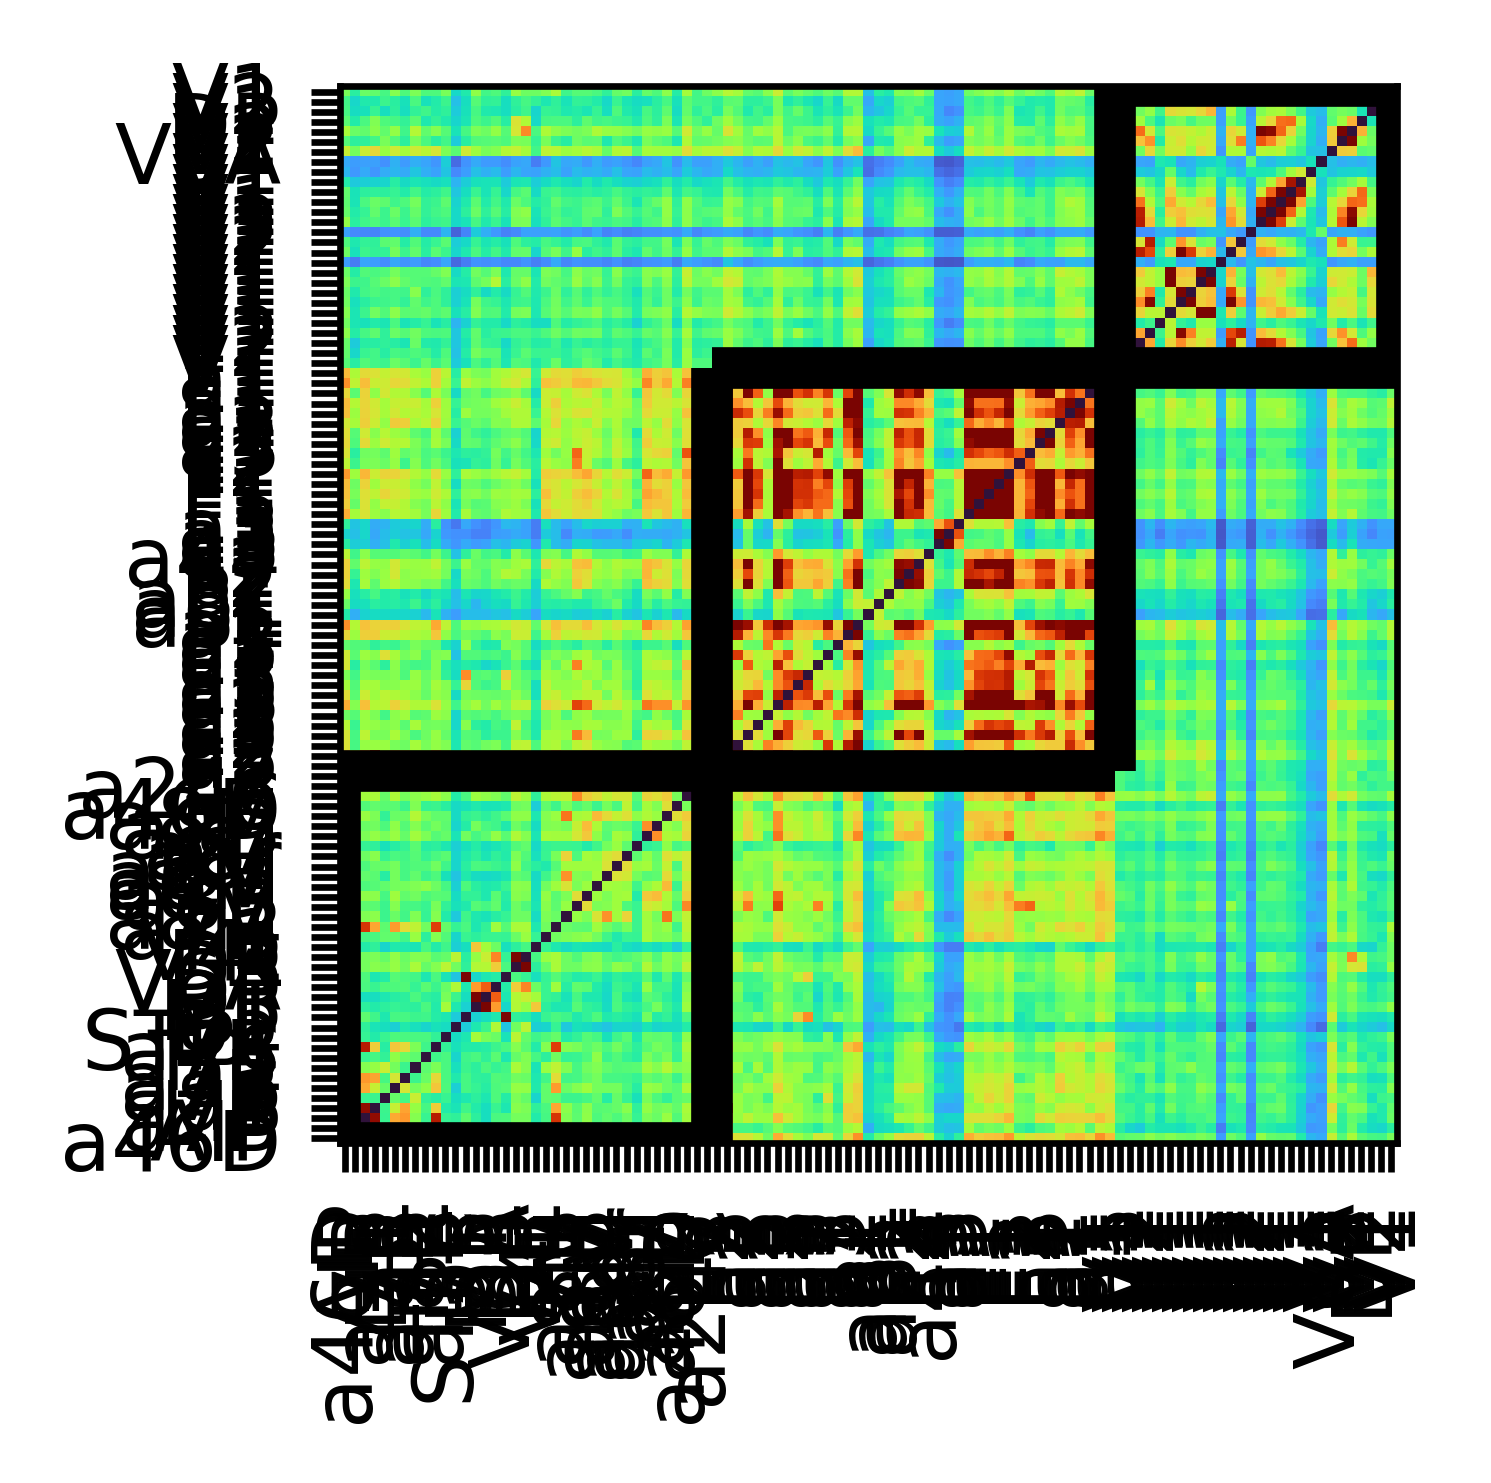

In [20]:
fig = plt.figure(figsize=(5, 5), dpi=600)

plt.subplot(1, 2, 1)
plot_adj_modular(
    A,
    ci_A,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="turbo",
    color="k",
)
"""
plt.subplot(1, 2, 2)
plot_adj_modular(
    B,
    ci_A,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="turbo",
    color="k",
)"""

In [21]:
kij_task, ci_task = [], []
kij_fix, ci_fix = [], []
for f in tqdm([27, 35, 43]):
    out_1, out_2 = return_co_crackle_mat(A_task.sel(freqs=f))
    kij_task += [out_1]
    ci_task += [out_2]
    out_1, out_2 = return_co_crackle_mat(A_fix.sel(freqs=f), surrogate=False)
    kij_fix += [out_1]
    ci_fix += [out_2]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.17s/it]


In [22]:
kij_task = xr.concat(kij_task, "freqs").assign_coords(dict(freqs=[27, 35, 43]))
kij_fix = xr.concat(kij_fix, "freqs").assign_coords(dict(freqs=[27, 35, 43]))
ci_task = xr.concat(ci_task, "freqs").assign_coords(dict(freqs=[27, 35, 43]))
ci_fix = xr.concat(ci_fix, "freqs").assign_coords(dict(freqs=[27, 35, 43]))

In [23]:
roi_s = kij_task.sources.values

regions = [areas_dict[r.lower()] for r in roi_s]

from sklearn import preprocessing

pre = preprocessing.LabelEncoder()
pre.fit(regions)
ci_ = pre.transform(regions) + 1

In [24]:
mod2reg = dict(zip(ci_, regions))

In [25]:
def inter_co_crackle(trial_type=1):

    inter_kijs = []

    for session in tqdm(sessions):

        kij = data_loader.load_co_crakcle(
            session=session, trial_type=trial_type, strength=False, thr=0
        )

        rois = kij.sources.data

        sca = ["Caudate", "Claustrum", "Thal", "Putamen"]

        idx_sca = np.asarray([roi not in sca for roi in rois])

        kij = kij.isel(sources=idx_sca, targets=idx_sca)
        rois = rois[idx_sca]

        areas_dict = get_areas()
        regions = np.asarray([areas_dict[roi.lower()] for roi in rois])

        unique_regions = np.unique(regions)
        nregions = len(unique_regions)

        nfreqs, ntimes = kij.shape[2:]
        freqs = kij.freqs.data

        sources, targets = np.tril_indices(nregions, k=0)
        npairs = len(sources)
        pairs = [
            f"{s}-{t}" for s, t in zip(unique_regions[sources], unique_regions[targets])
        ]

        inter_kij = np.zeros((npairs, nfreqs, ntimes))

        for p, (s, t) in enumerate(zip(sources, targets)):
            inter_kij[p,] = kij.isel(
                sources=regions == unique_regions[s],
                targets=regions == unique_regions[t],
            ).mean(("sources", "targets"))

        inter_kij = xr.DataArray(
            inter_kij,
            dims=("roi", "freqs", "times"),
            coords=dict(roi=pairs, freqs=freqs),
        )

        inter_kijs += [inter_kij]

    inter_kijs = xr.concat(inter_kijs, "sessions")
    sources, targets = _extract_roi(inter_kijs.roi.data, "-")
    idx = np.asarray(["same" if s == t else "diff" for s, t in zip(sources, targets)])
    inter_kijs = inter_kijs.assign_coords({"roi": idx})
    inter_kijs = inter_kijs.groupby("roi").mean("roi")
    return confidence_interval(inter_kijs, axis=0, n_boots=1000).squeeze()


inter_kij_task = inter_co_crackle(trial_type=1)
inter_kij_fix = inter_co_crackle(trial_type=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 19.21it/s]
    Estimating CI (cis=[95], axis=0, n_boots=1000, skipna=True, random_state=None)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 23.19it/s]
    Estimating CI (cis=[95], axis=0, n_boots=1000, skipna=True, random_state=None)


/tmp/ipykernel_577977/421804513.py:131: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("turbo")


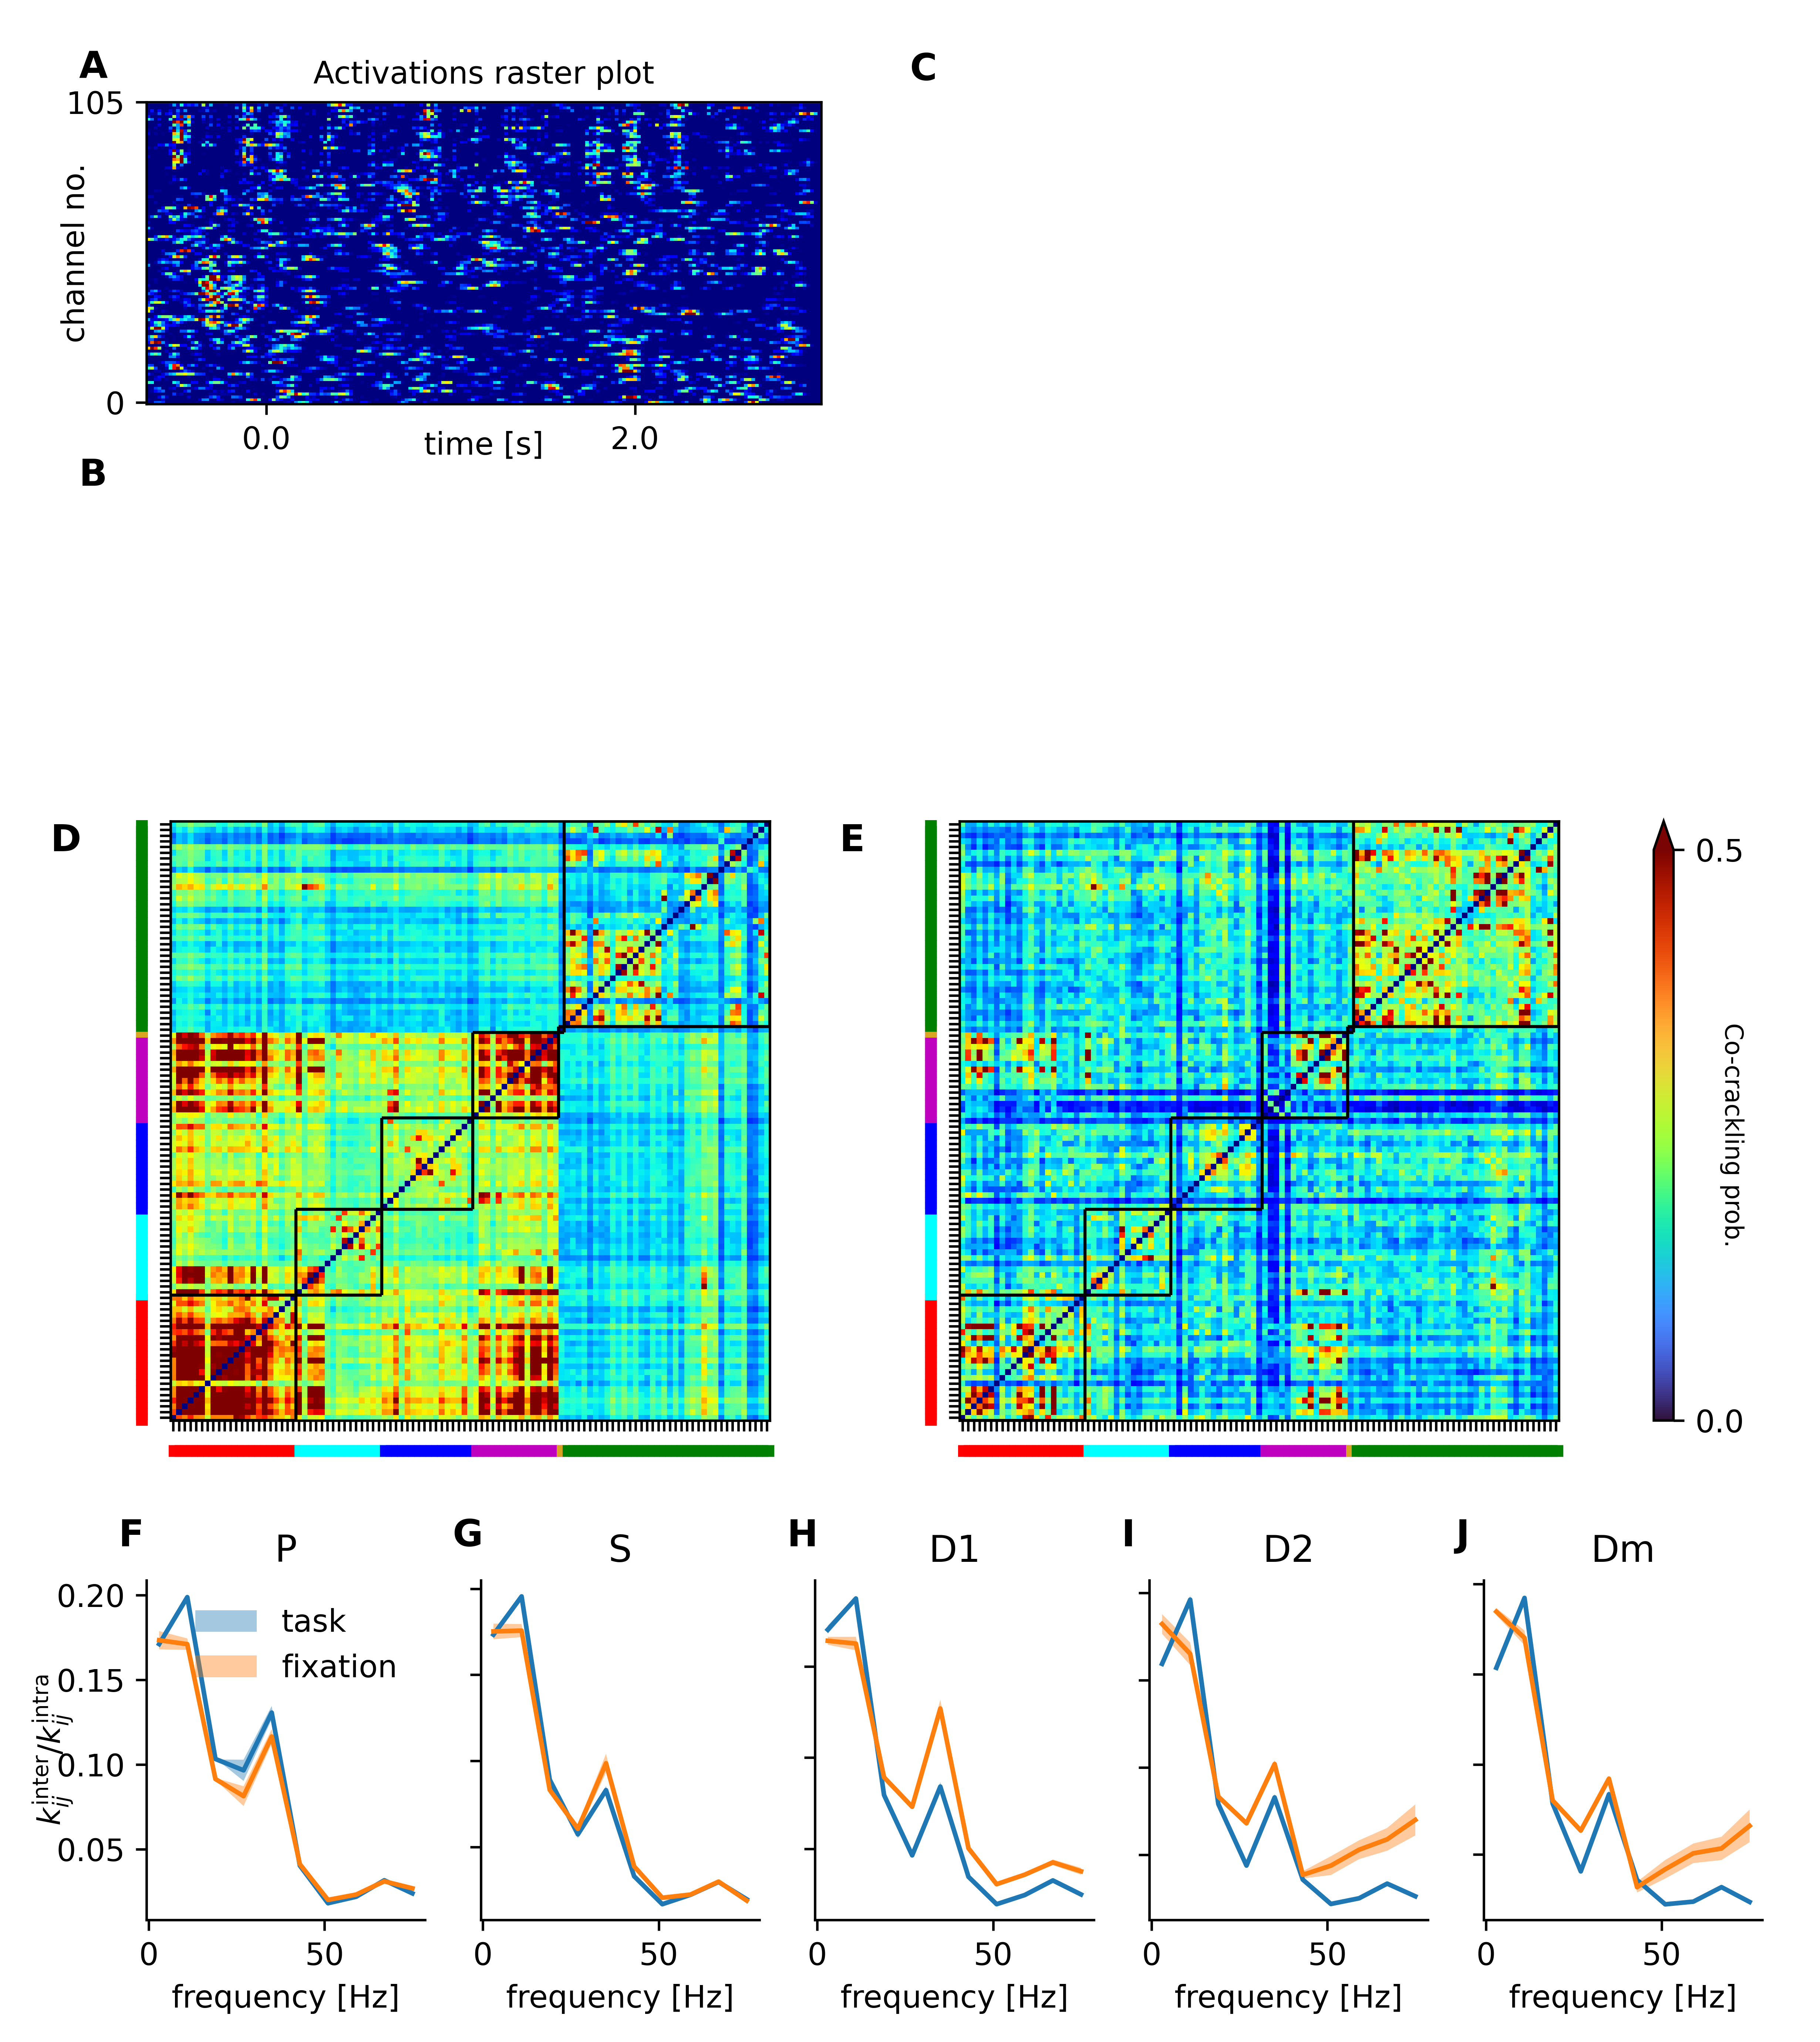

In [26]:
fig = plt.figure(figsize=(8, 9), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.07,
    right=0.45,
    hspace=0.4,
    bottom=0.67,
    top=0.96,
    height_ratios=(1, 0.6),
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.50,
    right=0.95,
    bottom=0.65,
    top=0.95,
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=3,
    left=0.03,
    right=0.93,
    bottom=0.3,
    top=0.6,
    wspace=0.0,
    width_ratios=(2, 2, 0.05),
)

gs3 = fig.add_gridspec(
    nrows=1,
    ncols=5,
    left=0.07,
    right=0.98,
    hspace=0.1,
    bottom=0.05,
    top=0.22,
)


axs0 = [plt.subplot(gs0[i]) for i in range(2)]
plt.sca(axs0[0])
tidx = [np.abs(A_task.times.data - t).argmin() for t in [0.0, 2.0]]
plt.imshow(
    A_task.sel(trials=4, freqs=27),
    cmap="jet",
    origin="lower",
    aspect="auto",
    vmax=5,
    vmin=0,
)
plt.xticks(tidx, [0.0, 2.0])
plt.yticks([0, 105], fontsize=10)
plt.ylabel("channel no.", labelpad=-8, fontsize=10)
plt.xlabel("time [s]", labelpad=-8, fontsize=10)
plt.title("Activations raster plot", fontsize=10)
plt.sca(axs0[1])
plt.axis("off")


axs1 = plt.subplot(gs1[0])
plt.sca(axs1)
plt.axis("off")

axs2 = [plt.subplot(gs2[i]) for i in range(3)]


plt.sca(axs2[0])

np.fill_diagonal(kij_task.sel(times=3, freqs=27).data, 0)

ci, q = return_consensus_vector(
    kij_task.sel(times=3, freqs=27),
    fmod=modularity_louvain_dir,
    nruns=100,
    verbose=False,
)

plot_adj_modular(
    kij_task.sel(times=2, freqs=35),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="jet",
    color="k",
    lw=1,
)

plt.xticks(fontsize=5)


def set_ticks_square(ticks="x", fontsize=5):
    if ticks == "x":
        f_ticks = plt.xticks
    else:
        f_ticks = plt.yticks
    tks = f_ticks(fontsize=fontsize)
    channels = [tks[1][i].get_text() for i in range(len(tks[1]))]
    f_ticks(range(len(tks[1])), ["■"] * len(tks[1]))
    tks_color = [colors[areas_dict[roi.lower()]] for roi in channels]
    [tks[1][i].set_color(tks_color[i]) for i in range(len(tks[1]))]


set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

np.fill_diagonal(kij_fix.sel(times=3, freqs=27).data, 0)


plt.sca(axs2[1])
plot_adj_modular(
    kij_fix.sel(times=2, freqs=35),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="jet",
    color="k",
    lw=1,
)
set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

plt.sca(axs2[2])
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.5)
cmap = matplotlib.cm.get_cmap("turbo")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 0.5],
    cax=axs2[-1],
    extend="max",
)
cbar.ax.set_ylabel("Co-crackling prob.", fontsize=8, rotation=270, labelpad=0)

axs3 = [plt.subplot(gs3[i]) for i in range(5)]

for t in range(len(axs3)):
    plt.sca(axs3[t])
    x = inter_kij_task.isel(times=t, roi=0) / inter_kij_task.isel(times=t, roi=1)
    y = inter_kij_fix.isel(times=t, roi=0) / inter_kij_fix.isel(times=t, roi=1)

    x.mean("bound").plot(x="freqs")
    plt.fill_between(x.freqs, x.isel(bound=0), x.isel(bound=1), alpha=0.4, label="task")
    y.mean("bound").plot(x="freqs")
    plt.fill_between(
        x.freqs, y.isel(bound=0), y.isel(bound=1), alpha=0.4, label="fixation"
    )
    [axs3[t].spines[key].set_visible(False) for key in ["top", "right"]]

    if t == 0:
        plt.ylabel(
            r"$k_{ij}^{\rm inter}$/$k_{ij}^{\rm intra}$", fontsize=10, labelpad=-6
        )
        plt.legend(frameon=False, fontsize=10)
    else:
        plt.ylabel("")
        plt.setp(axs3[t].get_yticklabels(), visible=False)
    plt.xlabel("frequency [Hz]", fontsize=10)
    plt.title(f"{stage_labels[t]}")

bg = plot.Background(visible=False)

axs = axs0 + [axs1] + axs2[:2] + axs3

plot.add_panel_letters(
    fig,
    axes=axs,
    fontsize=12,
    xpos=[-0.1] * 2 + [0] + [-0.2] * 2 + [-0.1] * 5,
    ypos=[1.08] * 2 + [1.07] + [0.95] * 2 + [1.1] * 5,
)

plt.savefig("figures/n4/figure10_5.pdf")

In [27]:
def return_module_region_specificity(av, time, freq, surrogate=False):
    rois = av.roi.data.copy()
    regions = [areas_dict[roi.lower()] for roi in rois]
    unique_regions, count_unique_regions = np.unique(regions, return_counts=True)
    reg2count = dict(zip(unique_regions, count_unique_regions))
    ci = av.sel(times=time, freqs=freq).data.copy()

    if surrogate:
        np.random.shuffle(ci)

    count_unique_regions = count_unique_regions / count_unique_regions.sum() + 1e-10
    Hmax = -(count_unique_regions * np.log(count_unique_regions)).sum()

    F_mu = np.zeros(ci.max())

    for m in range(ci.max()):
        rois_ci = [areas_dict[roi.lower()] for roi in rois[ci == m + 1]]
        r, c = np.unique(rois_ci, return_counts=True)
        c = c / c.sum() + 1e-100

        F_mu[m] = 1 + (c * np.log(c)).sum() / Hmax

    F_mu = xr.DataArray(F_mu, dims=("module"))

    return F_mu

In [28]:
freqs = ci_task.freqs.data

MP_surr = np.zeros((2, len(freqs)))
for i, freq in enumerate(freqs):
    t = np.stack(
        [
            return_module_region_specificity(ci_task, 3, freq, surrogate=True)
            for i in range(100)
        ],
        0,
    )

    MP_surr[:, i] = np.median(np.quantile(t, 0.05, axis=0)), np.median(
        np.quantile(t, 0.95, axis=0)
    )

In [29]:
MP = xr.concat(
    [
        confidence_interval(
            return_module_region_specificity(ci_task, 3, freq, surrogate=False),
            n_boots=50,
        ).squeeze()
        for freq in freqs
    ],
    "freqs",
)

    Estimating CI (cis=[95], axis=0, n_boots=50, skipna=True, random_state=None)
    Estimating CI (cis=[95], axis=0, n_boots=50, skipna=True, random_state=None)
    Estimating CI (cis=[95], axis=0, n_boots=50, skipna=True, random_state=None)


In [30]:
co_k = co_crackling_adj(A_task.sel(times=slice(0, 0.4), trials=4, freqs=27).data)

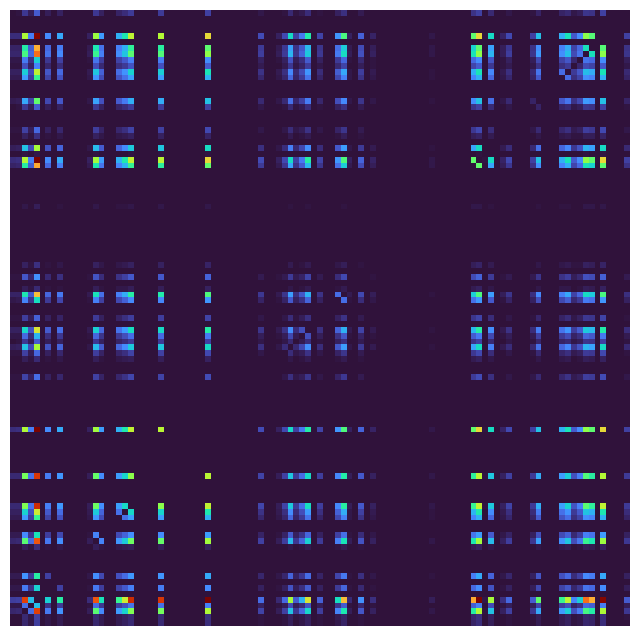

In [31]:
plt.figure(figsize=(8, 8))
for i in range(5):
    plt.imshow(co_k[..., i], aspect="auto", origin="lower", cmap="turbo")
    plt.axis("off")
    plt.savefig(f"figures/n4/cok_{i}.png")

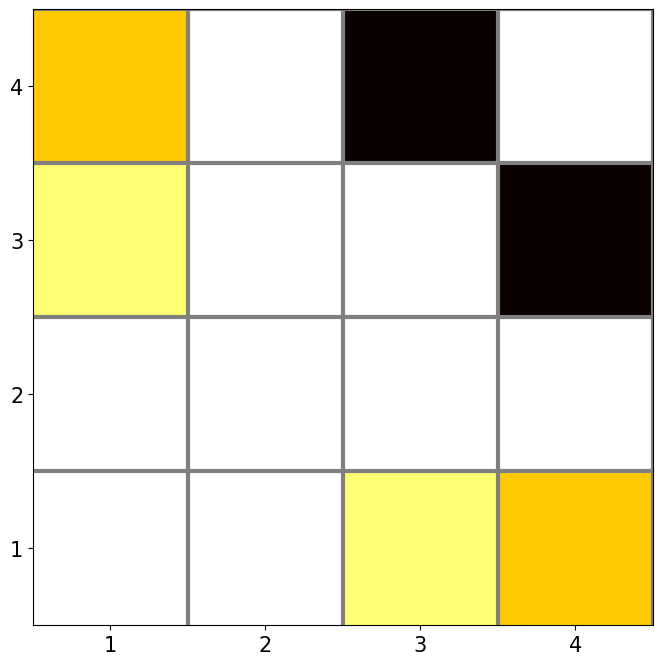

In [32]:
b = np.array([1, 0, 3, 7])
out = np.outer(b, b)
np.fill_diagonal(out, 0)
plt.figure(figsize=(8, 8))
plt.imshow(out, aspect="auto", origin="lower", cmap="hot_r")
plt.xticks(range(0, 4), range(1, 5), fontsize=15)
plt.yticks(range(0, 4), range(1, 5), fontsize=15)
[plt.hlines(0.5 + i, -0.5, 3.5, color="gray", lw=3) for i in range(4)]
[plt.vlines(0.5 + i, -0.5, 3.5, color="gray", lw=3) for i in range(4)]
plt.savefig(f"figures/n4/cok_example.png")

#### Figure paper

In [33]:
import numpy as np
import scipy.stats as st


def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen + 1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d / kern2d.sum()


def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )


x = np.linspace(-100, 100, 1000)

sA = (
    gaussian(x, -50, 6)
    + gaussian(x, 50, 6)
    + gaussian(x, 0, 6)
    + np.random.normal(0, 0.01, 1000)
)
sB = gaussian(x, 50, 6) + np.random.normal(0, 0.01, 1000)


tA = sA.copy() + np.random.normal(0, 0.01, 1000)
tB = gaussian(x, -50, 6) + np.random.normal(0, 0.01, 1000)
tC = gaussian(x, -50, 6) + gaussian(x, 50, 6) + np.random.normal(0, 0.01, 1000)
tD = -gaussian(x, 50, 6) + np.random.normal(0, 0.01, 1000)

S = [sA, sB]
T = [tA, tB, tC, tD]

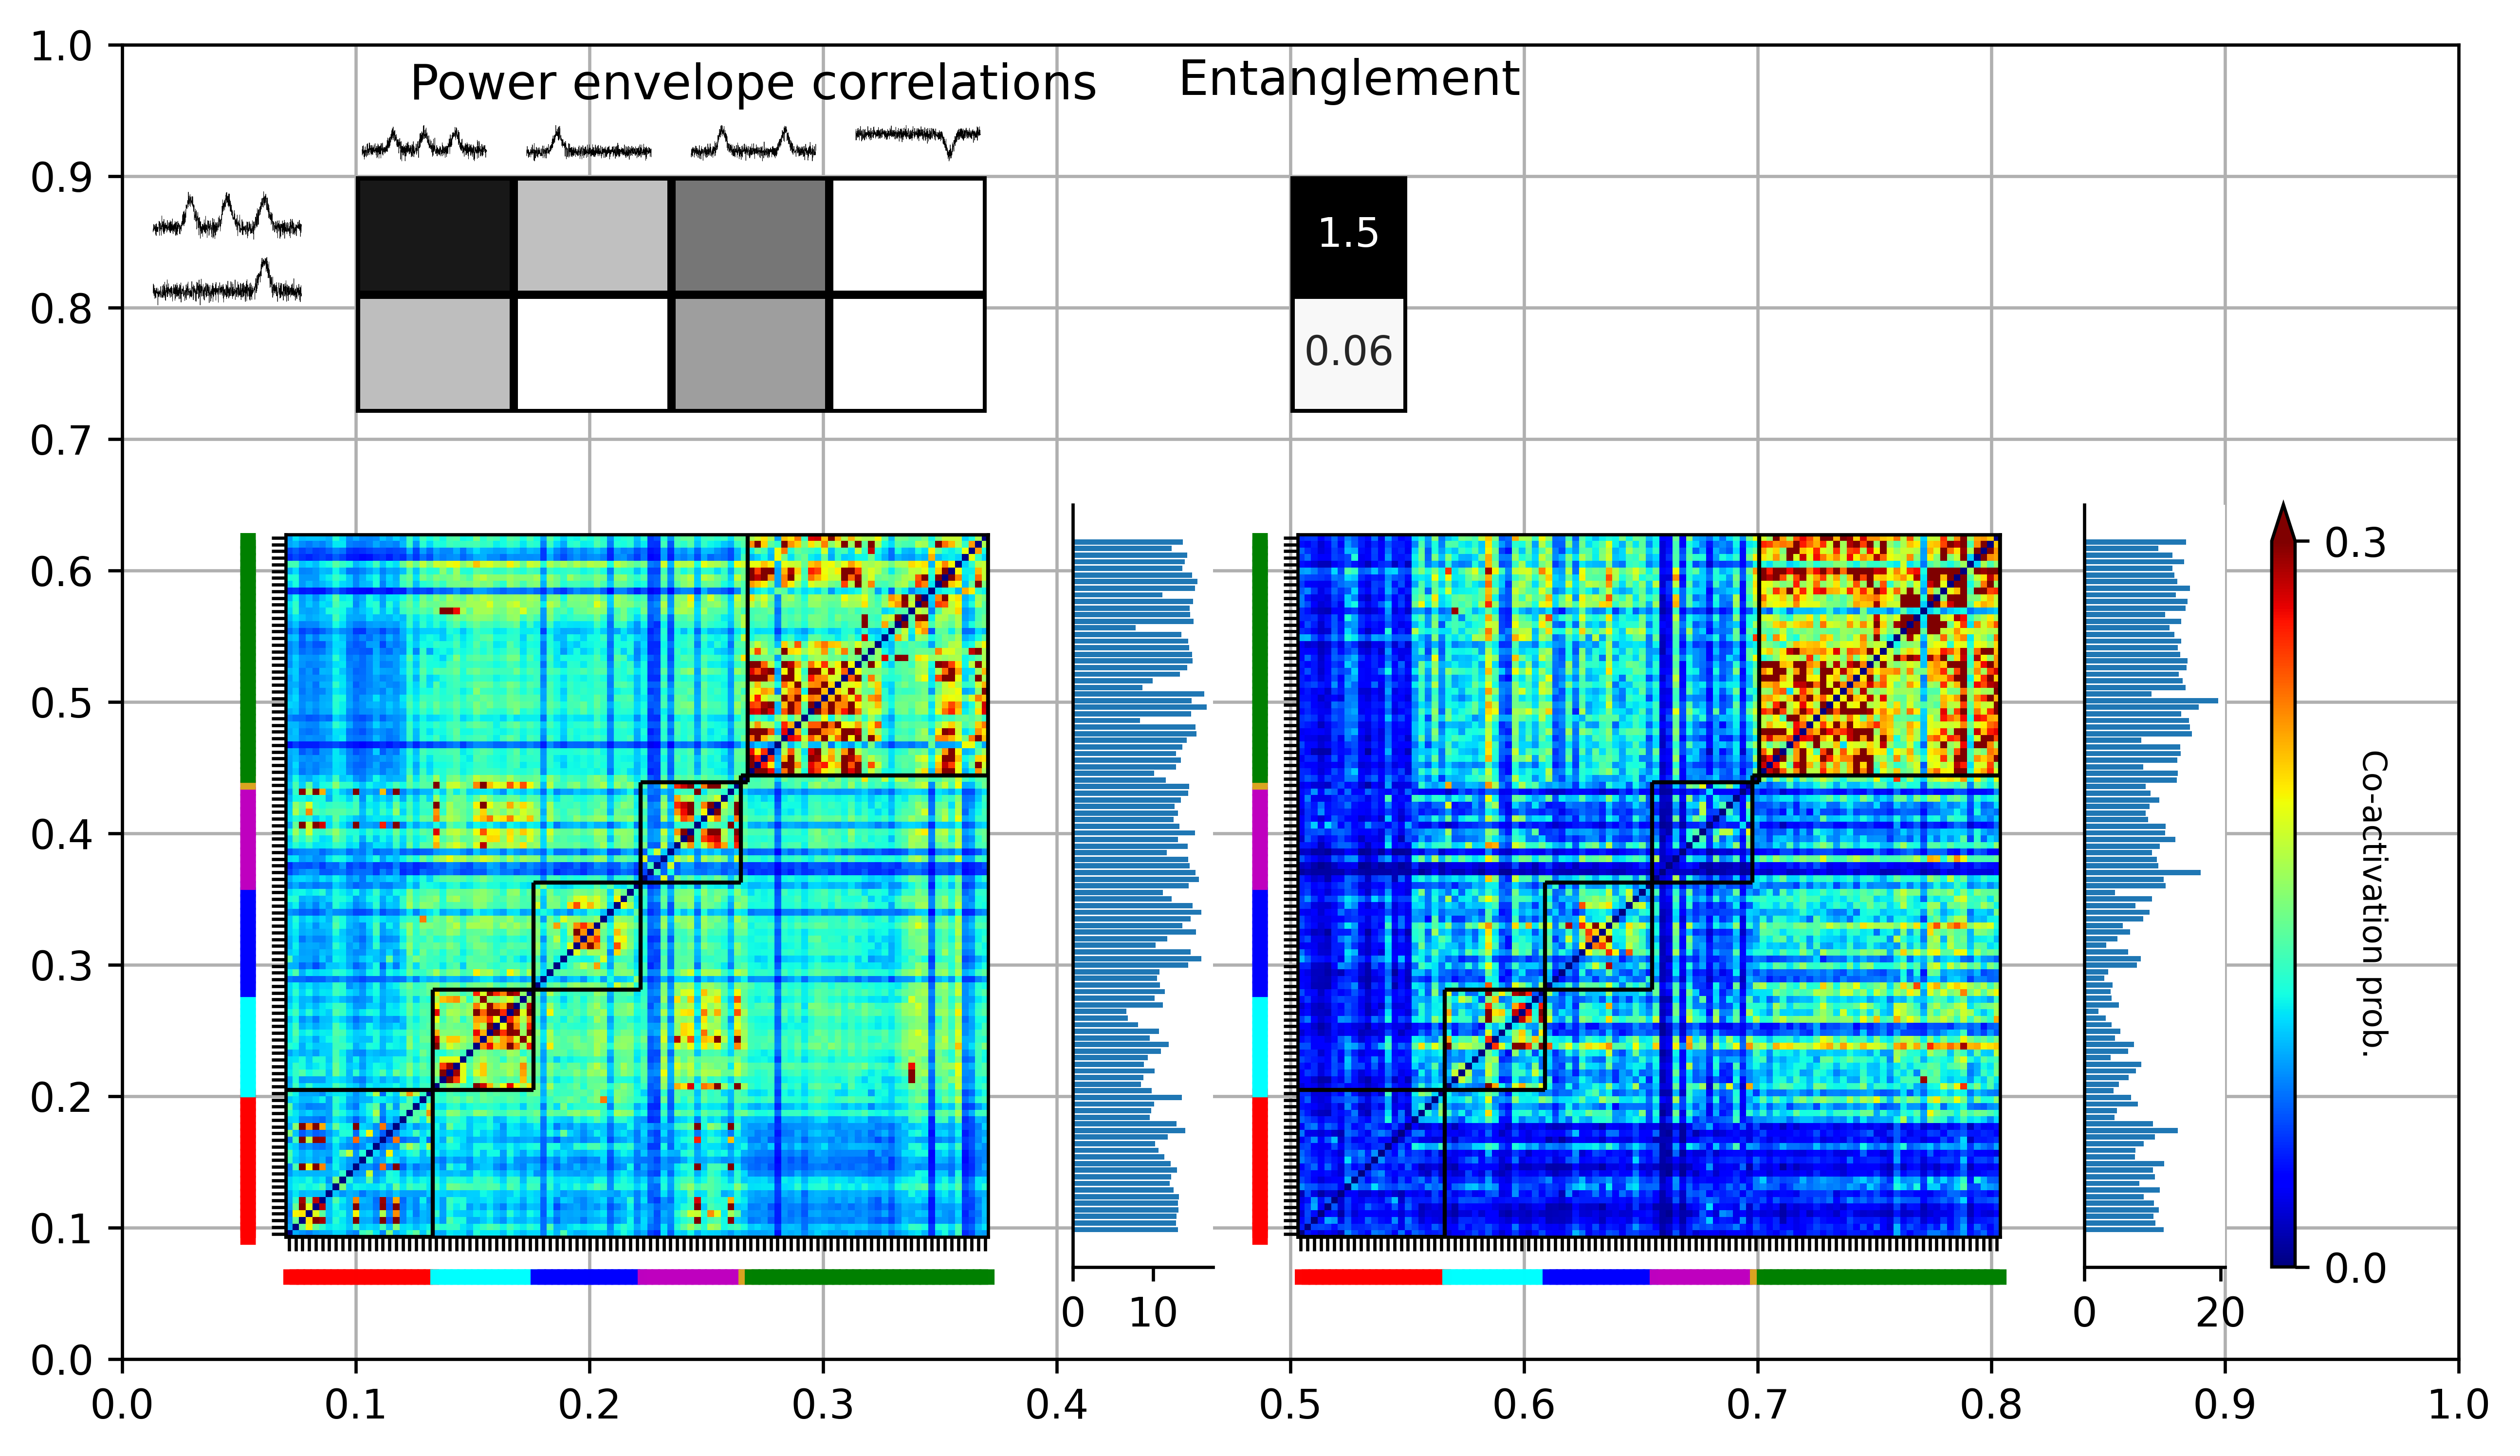

In [34]:
fig = plt.figure(figsize=(8, 4.5), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.1,
    right=0.37,
    hspace=0.2,
    bottom=0.72,
    top=0.90,
)

gs0ent = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.5,
    right=0.55,
    hspace=0.2,
    bottom=0.72,
    top=0.90,
)


gs0_sig1 = fig.add_gridspec(
    nrows=1,
    ncols=4,
    left=0.1,
    right=0.37,
    hspace=0.2,
    bottom=0.91,
    top=0.94,
)

gs0_sig2 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.01,
    right=0.08,
    hspace=0.2,
    bottom=0.85,
    top=0.89,
)

gs0_sig3 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.01,
    right=0.08,
    hspace=0.2,
    bottom=0.80,
    top=0.84,
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.50,
    right=0.95,
    bottom=0.65,
    top=0.95,
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=4,
    left=0.07,
    right=0.90,
    bottom=0.07,
    top=0.65,
    wspace=0.2,
    width_ratios=(1, 0.2, 1, 0.2),
)

gs2cbar = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.92,
    right=0.93,
    bottom=0.07,
    top=0.65,
)

axs0 = [plt.subplot(gs0[i]) for i in range(1)]
axs0ent = plt.subplot(gs0ent[0])
axs0_sig1 = [plt.subplot(gs0_sig1[i]) for i in range(4)]
axs0_sig2 = [plt.subplot(gs0_sig2[0]), plt.subplot(gs0_sig3[0])]
axs2 = [plt.subplot(gs2[i]) for i in range(4)]
axs2cbar = plt.subplot(gs2cbar[0])

############################### CARTOON ###############################
plt.sca(axs0[0])
ccA = np.corrcoef(sA, [tA, tB, tC, tD])[0, 1:]
ccB = np.corrcoef(sB, [tA, tB, tC, tD])[0, 1:]

cc = np.stack([ccA, ccB], axis=0)

sns.heatmap(
    cc, cmap="Greys", vmin=0, vmax=1, cbar=False, linewidths=2, linecolor="black"
)
plt.xticks([])
plt.yticks([])

for pos, ax in enumerate(axs0_sig1):
    plt.sca(ax)
    plt.plot(T[pos], lw=0.1, color="k")
    if pos == 2:
        plt.title("Power envelope correlations")

    plt.axis("off")

for pos, ax in enumerate(axs0_sig2):
    plt.sca(ax)
    plt.plot(S[pos], lw=0.1, color="k")
    plt.axis("off")


plt.sca(axs0ent)
ent = np.array([ccA.sum(), ccB.sum()])[:, None]
sns.heatmap(
    ent,
    cmap="Greys",
    vmin=0,
    vmax=1,
    annot=ent,
    cbar=False,
    linewidths=2,
    linecolor="black",
)
plt.axis("off")
plt.title("Entanglement", pad=20)

############################### COCRACKLINGS ###############################

plt.sca(axs2[0])

np.fill_diagonal(kij_task.sel(times=3, freqs=27).data, 0)

ci, q = return_consensus_vector(
    kij_task.sel(times=2, freqs=27),
    fmod=modularity_louvain_dir,
    nruns=100,
    verbose=False,
)

plot_adj_modular(
    kij_task.sel(times=3, freqs=27),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="jet",
    color="k",
    lw=1,
)

plt.xticks(fontsize=5)


def set_ticks_square(ticks="x", fontsize=5):
    if ticks == "x":
        f_ticks = plt.xticks
    else:
        f_ticks = plt.yticks
    tks = f_ticks(fontsize=fontsize)
    channels = [tks[1][i].get_text() for i in range(len(tks[1]))]
    f_ticks(range(len(tks[1])), ["■"] * len(tks[1]))
    tks_color = [colors[areas_dict[roi.lower()]] for roi in channels]
    [tks[1][i].set_color(tks_color[i]) for i in range(len(tks[1]))]


set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

np.fill_diagonal(kij_fix.sel(times=3, freqs=27).data, 0)

plt.sca(axs2[2])
plot_adj_modular(
    kij_fix.sel(times=3, freqs=27),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="jet",
    color="k",
    lw=1,
)
set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

plt.sca(axs2[1])
ent = kij_task.sel(times=3, freqs=27).sum(axis=1)
plt.barh(range(105), ent)
[axs2[1].spines[key].set_visible(False) for key in ["top", "right"]]
plt.yticks([])

plt.sca(axs2[3])
ent = kij_fix.sel(times=3, freqs=27).sum(axis=1)
plt.barh(range(105), ent)
[axs2[3].spines[key].set_visible(False) for key in ["top", "right"]]
plt.yticks([])

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.3)
cmap = matplotlib.colormaps["jet"]

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 0.3],
    cax=axs2cbar,
    extend="max",
)
cbar.ax.set_ylabel("Co-activation prob.", fontsize=8, rotation=270, labelpad=0)

bg = plot.Background(visible=True)

plt.savefig("figures/main/figure5.pdf")

In [76]:
import numba as nb
import numpy as np


# @nb.njit
def temporal_RC(Gt, AggG, k, delta):
    N, _, T = Gt.shape

    # Precompute variables
    x = AggG.sum(axis=1)
    set_k = x > k
    size_Sk = set_k.sum()

    if size_Sk <= 3:
        return 0, np.zeros(T - delta), size_Sk

    M_s = np.zeros(T - delta)
    for t in range(T - delta):
        # Compute coherence measure for time step t
        neighs = Gt[..., t : t + delta][set_k, ...]
        neighs = neighs.sum(-1) >= neighs.shape[-1]
        neighs = np.logical_and(set_k, neighs)
        eps = neighs.sum(0)
        M_s[t] = np.mean(eps) / (size_Sk * (size_Sk - 1))

    return np.max(M_s), M_s, size_Sk

In [ ]:
coh_sig_file = None  # f'thr_{metric}_at_{at}_surr.nc'
wt = None
metric = "pec"
at = "cue"
s_id = 5

net = temporal_network(
    coh_file=f"{metric}_at_{at}.nc",
    coh_sig_file=coh_sig_file,
    wt=wt,
    align_to=at,
    early_cue=None,
    early_delay=None,
    q=0.7,
    date=sessions[s_id],
    trial_type=[1],
    behavioral_response=[1],
    monkey=monkey,
)

net.convert_to_adjacency()

  0%|          |  : 0/10 [00:00<?,       ?it/s]

In [21]:
G = net.A.sel(freqs=27)

In [36]:
agg_k = G.sum(dim="times").data

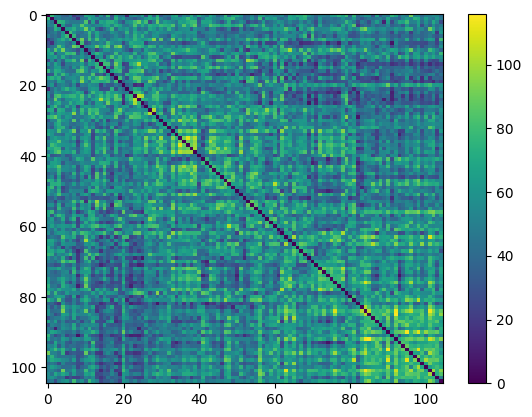

In [37]:
plt.imshow(agg_k[..., 30], aspect="auto")
plt.colorbar()

In [43]:
def return_RC(k, delta):

    RC = []
    for T in range(G.shape[0]):
        RC += [temporal_RC(G[..., T].data, agg_k[..., T], k, delta)[0]]
    return np.stack(RC)

In [44]:
ks = np.linspace(4, 20, 40, dtype=int)
deltas = np.linspace(1, 10, 50, dtype=int)

params = np.array(np.meshgrid(ks, deltas)).T.reshape(-1, 2)

In [ ]:
def _for_par(p):

    return return_RC(p[0], p[1])


# define the function to compute in parallel
parallel, p_fun = parallel_func(
    _for_par, n_jobs=20, verbose=False, total=params.shape[0]
)
# Compute the single trial coherence
RC = parallel(p_fun(p) for p in params)

  0%|          |  : 0/2000 [00:00<?,       ?it/s]

In [ ]:
RC = np.stack(RC, 1)

In [ ]:
plt.imshow(RC.reshape((582, 40, 50)).mean(0), aspect="auto", origin="lower")
plt.colorbar()

<Axes: >

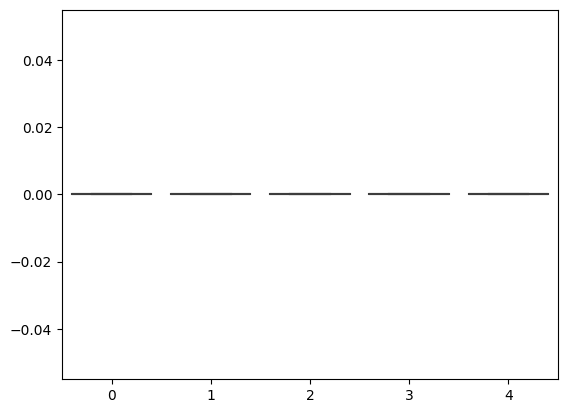

In [128]:
sns.boxplot(data=RC.T, showfliers=False)

In [66]:
core = xr.load_dataarray(
    os.path.join(
        os.path.expanduser("~/funcog/gda/Results/lucy"),
        "141024",
        "session01",
        "network",
        "pec_coreness_at_cue.nc",
    )
)

In [67]:
ci = confidence_interval(core.sel(freqs=35, times=slice(-0.5, 2)), axis=0).squeeze()

    Estimating CI (cis=[95], axis=0, n_boots=200, skipna=True, random_state=None)


Text(0.5, 0, 'time')

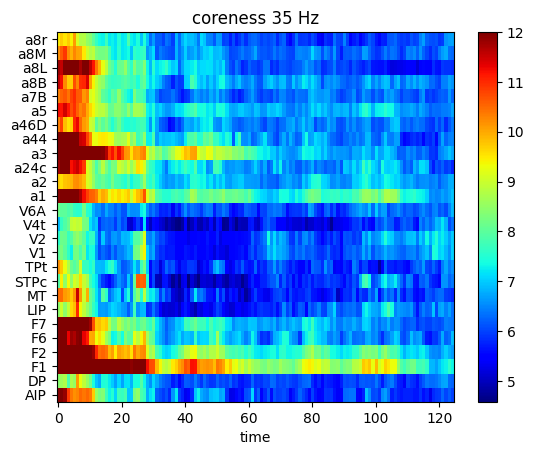

In [73]:
x = node_xr_remove_sca(ci.groupby("roi").mean("roi"))
plt.imshow(x.median("bound"), aspect="auto", origin="lower", cmap="jet", vmax=12)
plt.yticks(range(x.sizes["roi"]), x.roi.data)
plt.colorbar()
plt.title("coreness 35 Hz")
plt.xlabel("time")

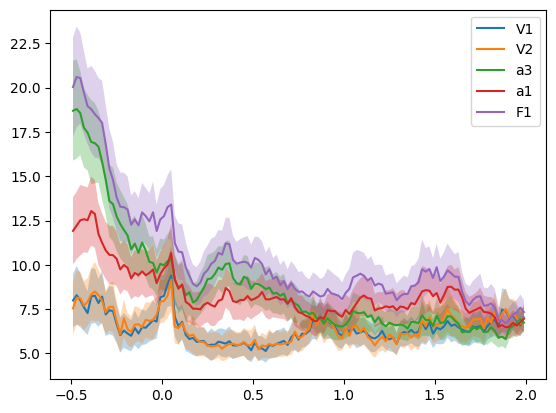

In [75]:
for roi in ["V1", "V2", "a3", "a1", "F1"]:
    plt.fill_between(
        x.times, x.sel(roi=roi).isel(bound=0), x.sel(roi=roi).isel(bound=1), alpha=0.3
    )
    plt.plot(x.times, x.sel(roi=roi).median("bound"), label=roi)
plt.legend()

### Co-crackling topology

In [17]:
plt.plot([:, 1])

SyntaxError: invalid syntax (1265765153.py, line 1)

In [29]:
import umap

In [30]:
reducer = umap.UMAP(n_components=2, min_dist=0.1, n_neighbors=10, n_jobs=20)

# , metric="hamming"

In [31]:
A_task = (power_task - power_task.mean("times")) / power_task.std(
    "times"
)  # power_task >= thr_task
A_task.values = (A_task * (A_task >= 0)).values

In [32]:
rois = A_task.roi.data

In [33]:
data = []
for ti, tf in stages:
    data += [
        A_task.sel(freqs=27, times=slice(ti, tf)).stack(obs=("trials", "times")).data.T
    ]

In [34]:
def return_prob_on_mod(data, ci):

    pm = []

    _, ord_m = np.unique(ci, return_counts=True)

    for i in range(ci.max()):

        pm += [data[:, ci == i + 1].mean(1)]

    return np.stack(pm, 1) + 1e-10


def return_nareas(data):
    nareas = []

    for i in range(data.shape[0]):

        nareas += [len(np.unique(rois[data[i]]))]

    nareas = np.stack(nareas)

    return nareas

In [35]:
def return_regions_fraction(data, t, rois):

    # Get the region name for each roi
    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in rois])

    unique_regions = np.unique(regions)
    nobs = data[t].shape[0]
    nregions = len(unique_regions)
    reg2idx = dict(zip(unique_regions, range(nregions)))

    raster = data[t]

    fr = np.zeros((nregions, nobs))

    for i in range(nobs):

        labels, counts = np.unique(regions[data[t][i, :]], return_counts=True)

        counts = counts / counts.sum()

        for ilabel, label in enumerate(labels):

            fr[reg2idx[label], i] = counts[ilabel]
    return fr

In [36]:
def return_regions_fraction(data, t, rois):

    # Get the region name for each roi
    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in rois])

    unique_regions = np.unique(regions)
    nobs = data[t].shape[0]
    nregions = len(unique_regions)
    reg2idx = dict(zip(unique_regions, range(nregions)))

    raster = data[t]

    fr = np.zeros((nregions, nobs))

    for i in range(nobs):

        labels, counts = np.unique(regions[data[t][i, :]], return_counts=True)

        counts = counts / counts.sum()

        for ilabel, label in enumerate(labels):

            fr[reg2idx[label], i] = counts[ilabel]
    return fr

In [37]:
embedding = [reducer.fit_transform(data[t]) for t in range(5)]

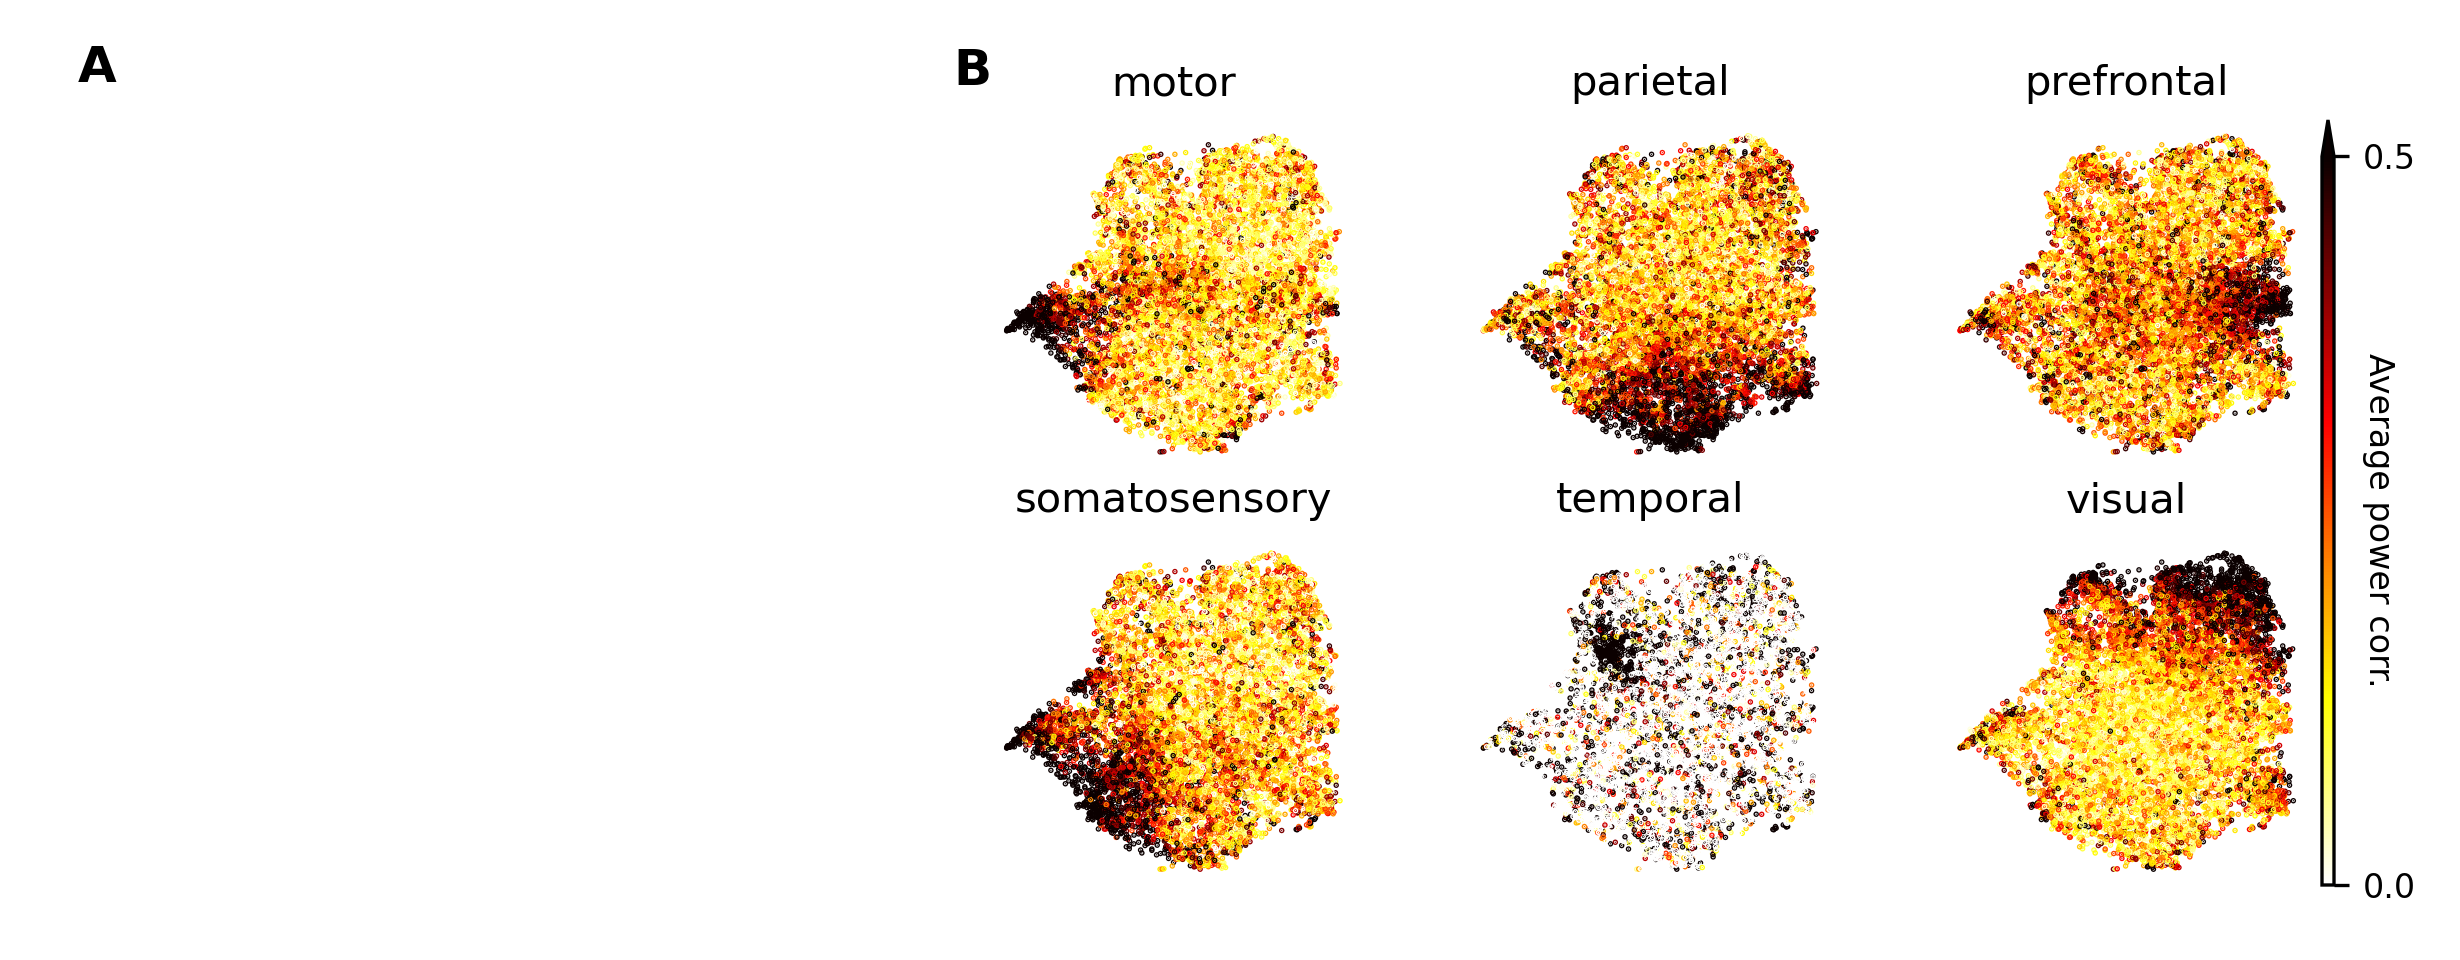

In [53]:
import matplotlib


def plot_umap_embedding(ax, t, colors, vmin=0, vmax=0.5, cmap="hot_r", s=0.1):
    plt.sca(ax)
    sc = plt.scatter(
        embedding[t][:, 0],
        embedding[t][:, 1],
        s=s,
        c=colors,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )
    [ax.spines[key].set_visible(False) for key in ["top", "right", "left", "bottom"]]
    plt.xticks([])
    plt.yticks([])


fig = plt.figure(figsize=(8, 3), dpi=300)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.05,
    right=0.35,
    wspace=0,
    bottom=0.05,
    top=0.90,
)

gs1 = fig.add_gridspec(
    nrows=2,
    ncols=3,
    left=0.4,
    right=0.95,
    wspace=0.3,
    bottom=0.05,
    top=0.90,
)

gs1_ax = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.955,
    right=0.96,
    wspace=0.3,
    bottom=0.05,
    top=0.90,
)

"""
gs2 = fig.add_gridspec(
    nrows=1,
    ncols=4,
    left=0.1,
    right=0.95,
    wspace=0.2,
    bottom=0.05,
    top=0.45,
    width_ratios=[1, 0.1, 1, 0.05],
)
"""
axs0 = plt.subplot(gs0[0])
axs1 = [plt.subplot(gs1[i]) for i in range(6)]
# axs2 = [plt.subplot(gs2[i]) for i in [0, 2, 3]]

ncomm = ci_.max()
pm = return_prob_on_mod(data[3], ci_)
for i in range(ncomm):
    plt.sca(axs1[i])
    plot_umap_embedding(axs1[i], 3, pm[:, i], vmin=0, vmax=0.7, cmap="hot_r", s=0.1)
    plt.title(f"{mod2reg[i + 1]}", fontsize=10)

axs1_ax = plt.subplot(gs1_ax[0])
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.5)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 0.5],
    cax=axs1_ax,
    extend="max",
)
cbar.ax.tick_params(labelsize=8, rotation=0)
cbar.ax.set_ylabel(r"Average power corr.", fontsize=8, rotation=270, labelpad=-5)

"""
fr = return_regions_fraction(data, 3, A_task.roi.data)
fr_colors = [colors[reg] for reg in unique_regions[fr.argmax(0)]]
plot_umap_embedding(axs2[0], 3, fr_colors, vmin=0, vmax=1, cmap=None, s=0.5)

p_fr = fr + 1e-10
H_fr = 1 + (((p_fr * np.log(p_fr)).sum(0)) / np.log(fr.shape[0]))


plot_umap_embedding(axs2[1], 3, H_fr, vmin=0, vmax=1, cmap="hot_r", s=0.5)


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 1],
    cax=axs2[2],
    extend="max",
)
cbar.ax.tick_params(labelsize=8, rotation=0)
cbar.ax.set_ylabel(r"P(region $\in$ mod. i)", fontsize=8, rotation=270, labelpad=0)
"""
plot.add_panel_letters(
    fig,
    axes=[axs0, axs1[0]],
    fontsize=12,
    xpos=[-0.1, -0.1],
    ypos=[1.05, 1.1],
)

plt.sca(axs0)
plt.axis("off")

bg = plot.Background(visible=False)

plt.savefig("figures/n4/figure11.png")

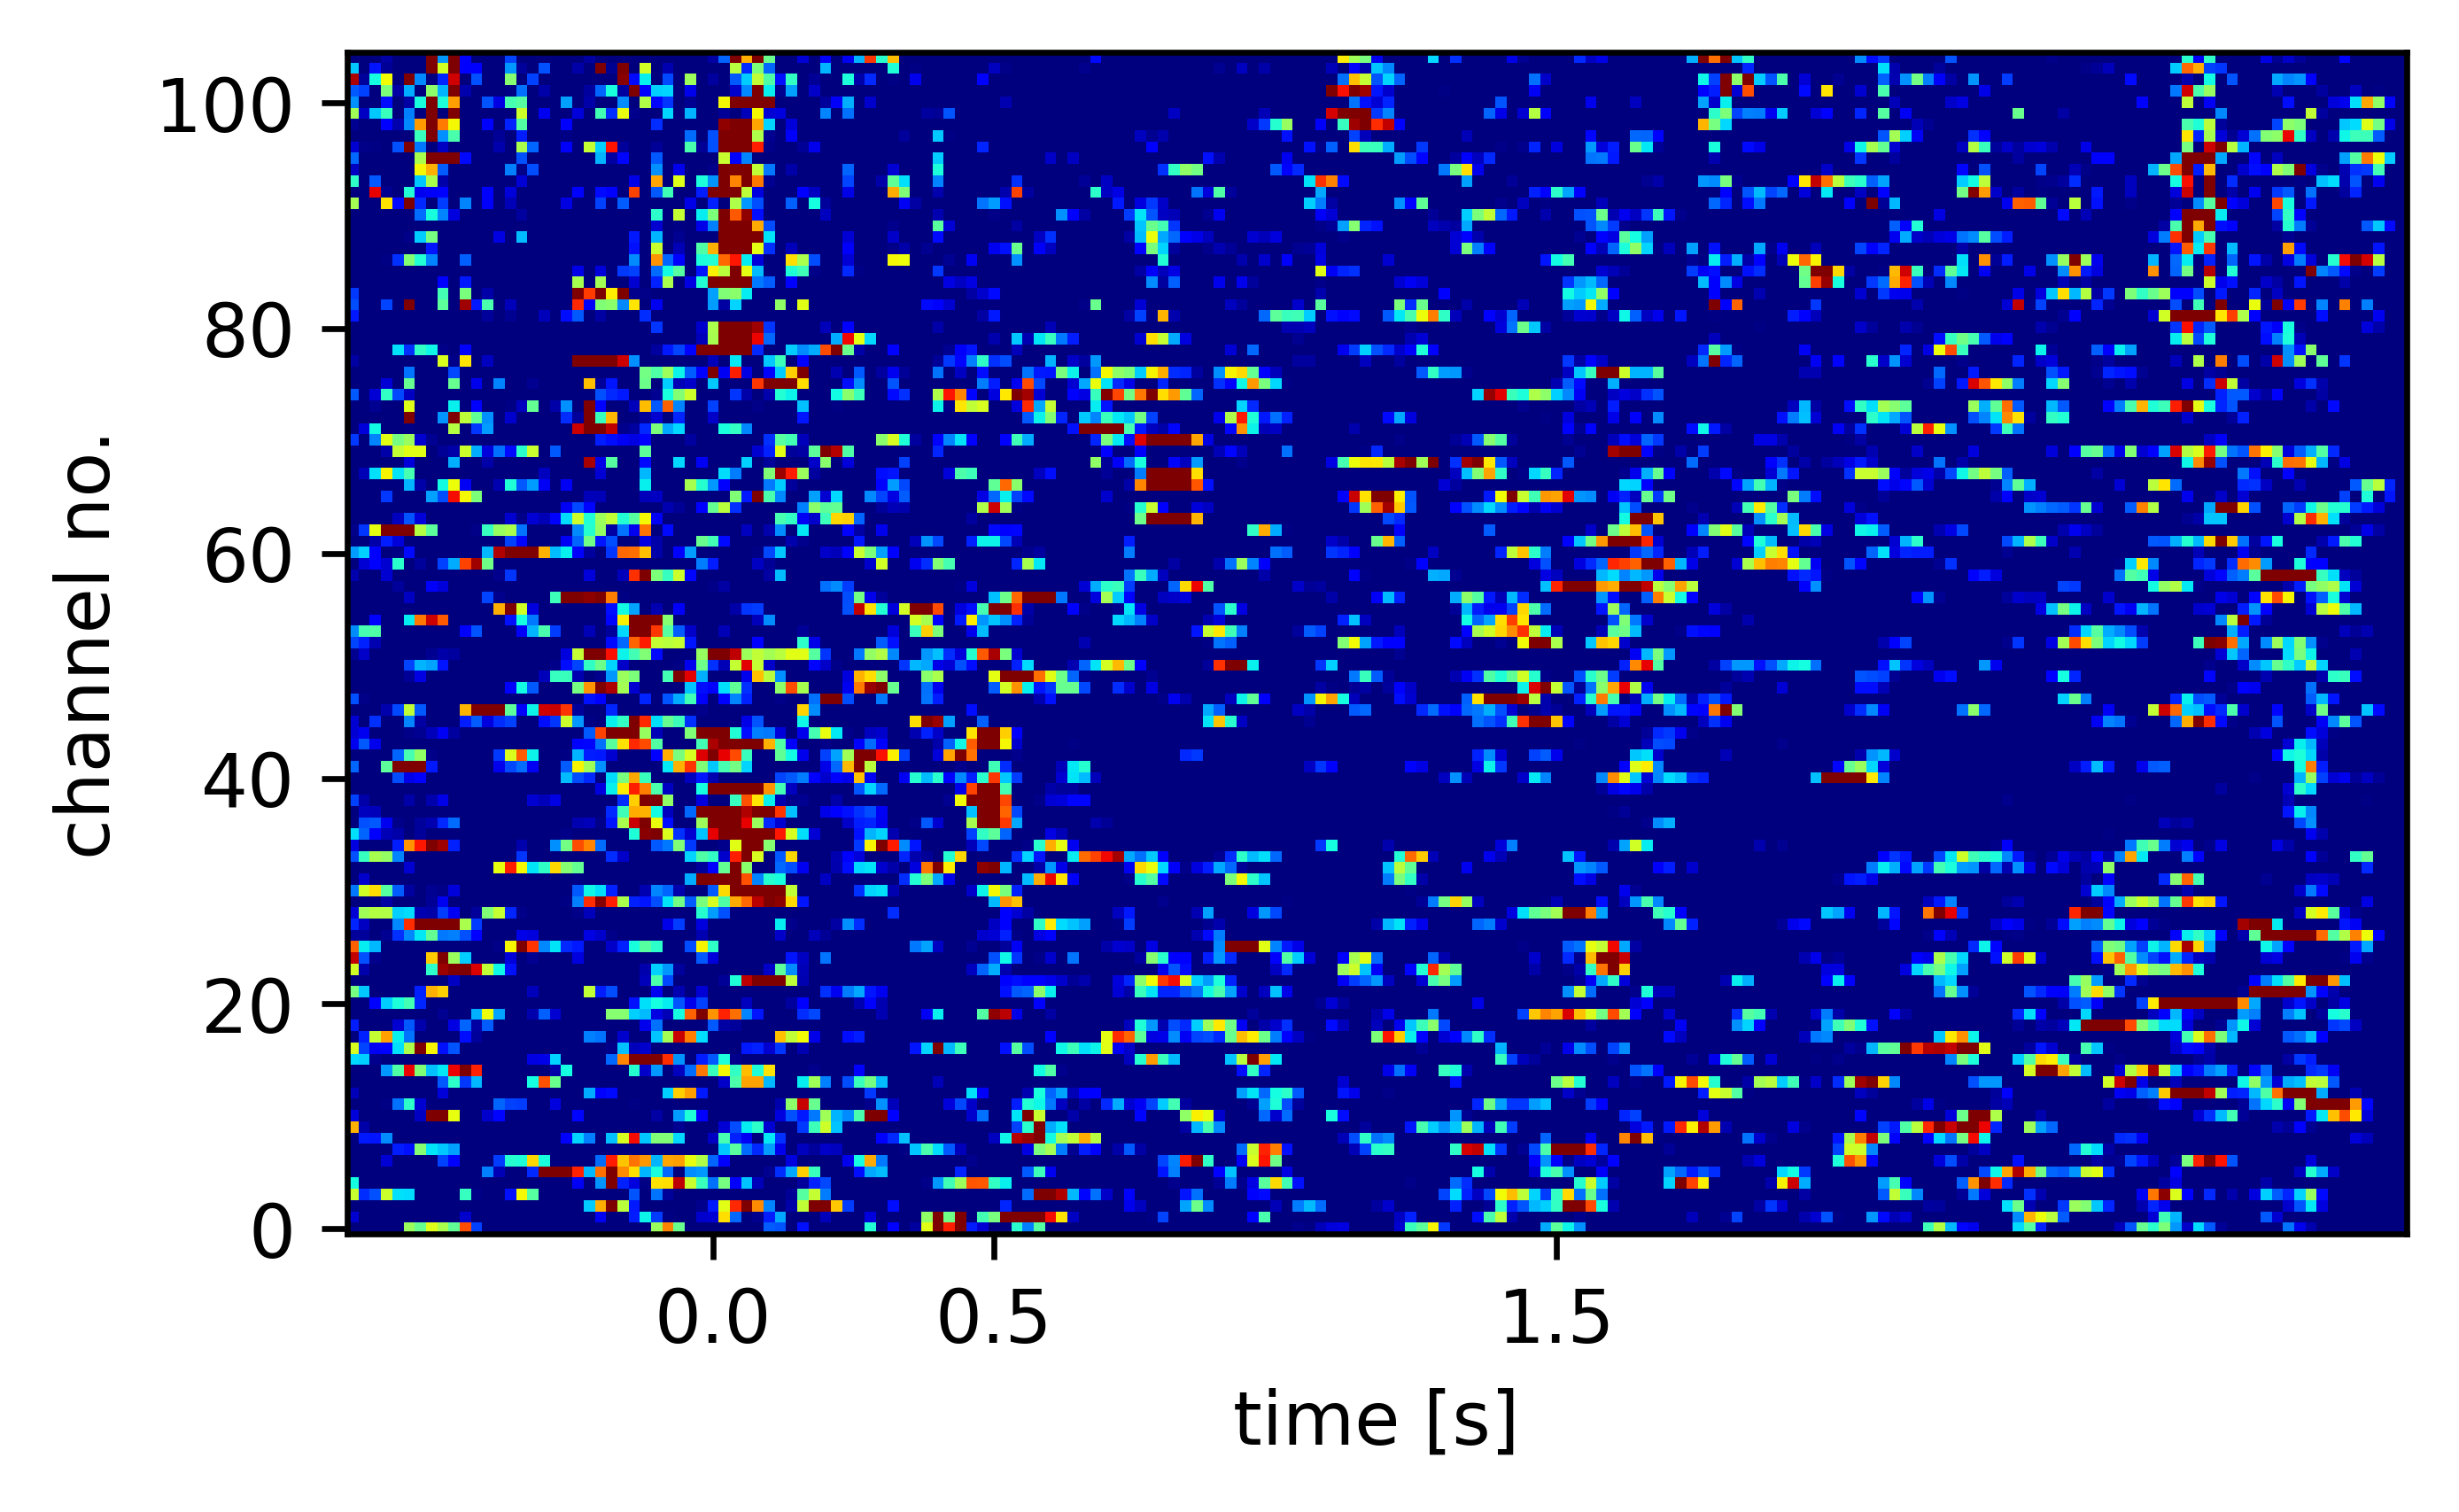

In [61]:
tidx = [np.abs(A_task.times.data - t).argmin() for t in [0.0, 0.5, 1.5]]
plt.figure(figsize=(5, 3), dpi=600)
plt.imshow(A_task.sel(freqs=27, trials=12), cmap="jet", origin="lower", vmax=3)
plt.xticks(tidx, [0.0, 0.5, 1.5])
plt.ylabel("channel no.")
plt.xlabel("time [s]")
plt.savefig("figures/n4/raster.pdf")